In [1]:
"""
XGBoost multiclassifier for roof materials in Denver, Colorado
"""

import os, sys, glob, time
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as rxr
import rasterio as rio
import xgboost as xgb
import optuna
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Functions script import
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

print(os.getcwd())

# maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-rooftop-mapping'
homedir = '/home/jovyan/data-store/data/iplant/home/maco4303/data/' # cyverse

print("Imports successful!")

/home/jovyan/data-store/opp-rooftop-mapping/code
Imports successful!


In [2]:
results_dir = os.path.join(homedir, 'OPP/results/xgboost-cv/')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving results to {results_dir}")

Saving results to /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/


In [3]:
# Load the image data

In [4]:
# Load our image data to check on the format
# stack_da_fp = os.path.join(maindir,'data/spatial/mod/denver_data/planet-data/denver_0623_psscene8b_final_norm.tif')
stack_da_fp = os.path.join(homedir,'OPP/planet/denver/denver_0815_psscene8b_final_norm.tif') # cyverse
stack_da = rxr.open_rasterio(stack_da_fp, masked=True, cache=False).squeeze()
print_raster(stack_da, open_file=False)
band_names = list(stack_da.long_name)
print(f"Band names: {band_names}")
del stack_da

shape: (14939, 6330)
resolution: (3.0, -3.0)
bounds: (489558.0, 4383960.0, 508548.0, 4428777.0)
sum: 15.8248291015625
CRS: EPSG:32613
NoData: None
Band names: ['nir', 'NDBIbg', 'NDBIrg', 'NISI', 'MNF1', 'NISI5x5']


In [5]:
# Load the reference data

In [6]:
# Load the training data (footprints)
# ref_fp = os.path.join(maindir,'data/spatial/mod/denver_data/training/denver_data_reference_footprints_sampled.gpkg')
ref_fp = os.path.join(homedir,'OPP/training/denver/denver_data_reference_footprints_sampled.gpkg')
ref = gpd.read_file(ref_fp)
ref.head()

,uid,class_code,description,areaUTMsqft,lotSizeSqft,nir,NDBIbg,NDBIrg,NISI,MNF1,NISI5x5,geometry
0,78TL,TL,Tile,271.028875,4710.0,-0.269367,0.761426,-0.261942,0.142143,-0.075536,1.295256,"MULTIPOLYGON (((502162.154 4397355.647, 502162..."
1,269TL,TL,Tile,3885.053236,22307.0,-0.491559,-0.228959,0.145086,-0.381386,-0.528288,1.630611,"MULTIPOLYGON (((503091.622 4397021.987, 503101..."
2,490TL,TL,Tile,2018.268605,6250.0,0.165630,0.121267,1.540670,-0.037652,-0.156279,0.792929,"MULTIPOLYGON (((501990.912 4396754.280, 502007..."
3,497TL,TL,Tile,273.843801,6370.0,-0.163570,-0.456508,-1.066501,-1.018041,-0.692620,0.178836,"MULTIPOLYGON (((502773.275 4396965.742, 502773..."
4,537TL,TL,Tile,281.649002,6000.0,0.124112,0.416955,0.378783,0.538502,0.390621,0.340135,"MULTIPOLYGON (((502162.107 4396885.437, 502168..."


In [7]:
print(ref['class_code'].value_counts())

class_code
CS    86561
WS    10642
AP     8117
TL     2843
CN     2757
SL      230
TG      228
Name: count, dtype: int64


In [23]:
# Create a numeric code column
ref['code'], _ = pd.factorize(ref['class_code'])

# Create a dictionary mapping class_code to code
code_mapping = dict(zip(ref['code'], ref['class_code']))
desc_mapping = dict(zip(ref['class_code'], ref['description']))

print(f'Code map: \n{code_mapping}\nDescription map: \n{desc_mapping}')

Code map: 
{0: 'TL', 1: 'WS', 2: 'CN', 3: 'AP', 4: 'SL', 5: 'TG', 6: 'CS'}
Description map: 
{'TL': 'Tile', 'WS': 'Wood shake/shingle', 'CN': 'Concrete', 'AP': 'Asphalt', 'SL': 'Slate', 'TG': 'Tar and gravel', 'CS': 'Composition Shingle'}


In [9]:
# Create a holdout sample for model evaluation later on

In [10]:
# Create the holdout data (independent from model training in CV)
holdout_fraction = 0.20 # excluding 20% of the data for holdout/independent testing
train_df, holdout_df, _ = split_training_data(ref, ts=holdout_fraction, vs=None) # no validation needed yet

print("Training set class distribution:\n", train_df[['class_code','code']].value_counts())
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Training set class distribution:
 class_code  code
CS          6       69248
WS          1        8513
AP          3        6493
TL          0        2274
CN          2        2205
SL          4         184
TG          5         182
Name: count, dtype: int64
Holdout set class distribution:
 class_code  code
CS          6       17313
WS          1        2129
AP          3        1624
TL          0         569
CN          2         552
SL          4          46
TG          5          46
Name: count, dtype: int64


In [11]:
# Parameter tuning using Optuna

In [12]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(train_df['code'])),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 1e-2),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 101, 1001),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1.0),
        'random_state': 44
    }

    # Stratified 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
    
    f1_scores = [] # to store the validation F1 for each fold
    
    for train_idx, val_idx in skf.split(train_df, train_df['class_code']):
        # Extract the train and validation sets
        fold_train = train_df.iloc[train_idx]
        fold_val = train_df.iloc[val_idx]

        # Undersample majority class in training set only
        fold_train_bal = balance_sampling(fold_train, ratio=5, strategy='undersample')

        # Calculate the class weights
        val_counts = fold_train_bal['code'].value_counts()
        total_samples = sum(val_counts)
        class_weights = np.array([total_samples / count for count in val_counts])
        class_weights_n = class_weights / class_weights.sum() # normalize the weights
        class_weights_n = {cls: weight for cls, weight in zip(np.unique(fold_train_bal['code']), class_weights)}

        # Define our train/validation sets
        X_train = fold_train_bal[band_names].astype(float)
        y_train = fold_train_bal['code'].astype(int)
        X_val = fold_val[band_names].astype(float)
        y_val = fold_val['code'].astype(int)
        
        del fold_train, fold_val, fold_train_bal # clear up space

        # Fit the XGBoost with params
        xgb_model = xgb.XGBClassifier(n_jobs=1, **params) # avoid over-using CPU resources
        xgb_model.fit(
            X_train, y_train,
            sample_weight=y_train.map(class_weights_n).values,
            verbose=False
        )

        # Evaluate F1-score on the validation set
        y_pred = xgb_model.predict(X_val)
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)

        del y_pred, f1, X_train, y_train, X_val, y_val, xgb_model

    # Calculate mean metrics across folds
    f1_ = np.mean(f1_scores)

    del f1_scores
    gc.collect()

    return f1_  # Optuna will maximize this score

print("Optuna function ready to go !!!")

Optuna function ready to go !!!


In [13]:
t0 = time.time()

print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Implement the optuna objective study
study = optuna.create_study(direction='maximize', study_name='denver_xgboost_tuning') # maximize the scoring criteria
study.optimize(objective, n_trials=200, n_jobs=-1, show_progress_bar=True)  # Adjust the number of trials as needed
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
# Retrieve the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters found: {best_params}")
# Save the Optuna study for later analysis
study.trials_dataframe().to_csv(os.path.join(results_dir, 'denver-xgboost-cv_optuna_trials.csv'), index=False)
print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

t2 = (time.time() - t0) / 60
print(f"Total elapsed time for 100 trials: {t2:.2f} minutes.")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



  0%|          | 0/200 [00:00<?, ?it/s]


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Best hyperparameters found: {'learning_rate': 0.0017472223984262216, 'max_depth': 6, 'n_estimators': 982, 'min_child_weight': 3, 'subsample': 0.5002215027207308, 'colsample_bytree': 0.5767395115585954, 'gamma': 8.601053095855774e-05}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Total elapsed time for 100 trials: 10.84 minutes.


In [14]:
best_params

{'learning_rate': 0.0017472223984262216,
 'max_depth': 6,
 'n_estimators': 982,
 'min_child_weight': 3,
 'subsample': 0.5002215027207308,
 'colsample_bytree': 0.5767395115585954,
 'gamma': 8.601053095855774e-05}

In [15]:
# Model run w/ best parameters

In [16]:
print("Holdout set class distribution:\n", holdout_df[['class_code','code']].value_counts())

Holdout set class distribution:
 class_code  code
CS          6       17313
WS          1        2129
AP          3        1624
TL          0         569
CN          2         552
SL          4          46
TG          5          46
Name: count, dtype: int64


In [19]:
t0 = time.time()

# Set up the stratified K-fold CV
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=44)

# Loop the folds
fold_idx = 1
# Define dataframes to store results for this feature set
all_fold_results = []  # to store the true/predicted
all_metric_results = [] # to store model performance across folds/n_estimators
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['class_code'])):
    t00 = time.time()
    print(f"Processing fold {fold_idx + 1}/{n_folds}...")

    # Get the train and validation splits for this fold
    fold_train = train_df.iloc[train_idx]
    fold_val = train_df.iloc[val_idx]

    # Apply random undersampling to the training data within this fold
    fold_train_bal = balance_sampling(fold_train, ratio=5, strategy='undersample')

    print(f"Train class distribution (fold {fold_idx + 1}):\n", fold_train_bal['code'].value_counts().to_dict())
    print(f"Validation class distribution (fold {fold_idx + 1}):\n", fold_val['code'].value_counts().to_dict())

    # Calculate the class weights
    val_counts = fold_train_bal['code'].value_counts()
    total_samples = sum(val_counts)
    class_weights = np.array([total_samples / count for count in val_counts])
    class_weights_n = class_weights / class_weights.sum() # normalize the weights
    class_weights_n = {cls: weight for cls, weight in zip(np.unique(fold_train_bal['code']), class_weights)}

    # Initialize the XGBoost classifier for multi-class classification
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(fold_train_bal['code'])),
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        gamma=best_params['gamma'],
        eval_metric=['mlogloss', 'auc', 'merror'], # track multiple evaluation metrics
        early_stopping_rounds=100, # stop if no improvement
        random_state=44
    )

    #################
    # Fit the model #

    # Define train/validation/holdout sets
    X_train = fold_train_bal[band_names].astype(float)
    y_train = fold_train_bal['code'].astype(int)
    X_val = fold_val[band_names].astype(float)
    y_val = fold_val['code'].astype(int)

    # Define our evaluation sets
    eval_set = [(X_train, y_train), (X_val, y_val)]

    xgb_model.fit(
        X_train, y_train,
        eval_set=eval_set,  # Specify train/validation/holdout sets for evaluation
        sample_weight=y_train.map(class_weights_n).values,
        verbose=False
    )
    
    # Retrieve the evaluation metrics for the fold
    eval_results = xgb_model.evals_result()
    # Store the performance metrics
    metrics_df = pd.DataFrame({
        'fold_idx': fold_idx + 1,
        'n_estimators': range(len(eval_results['validation_1']['mlogloss'])),
        'train_mlogloss': eval_results['validation_0']['mlogloss'],
        'val_mlogloss': eval_results['validation_1']['mlogloss'],
        'train_auc': eval_results['validation_0']['auc'],
        'val_auc': eval_results['validation_1']['auc'],
        'train_merror': eval_results['validation_0']['merror'],
        'val_merror': eval_results['validation_1']['merror']
    })
    all_metric_results.append(metrics_df)

    #####################################
    # Make prediction on validation set #
    
    # Predict on the validation set
    y_pred = xgb_model.predict(X_val)
    
    # Calculate the validation  accuracy and f1-score (weighted)
    f1_val = f1_score(y_val, y_pred, average='weighted')
    acc_val = accuracy_score(y_val, y_pred)

    print(f"\tFold [{fold_idx}] accuracy: {acc_val:.3f};\n\tF1-score: {f1_val:.3f};")
    
    # Store the metrics into the results data frame
    fold_results = pd.DataFrame({
        'fold_idx': fold_idx + 1,
        'val_f1': [f1_val] * len(y_val),
        'val_acc': [acc_val] * len(y_val),
        'val_labs': y_val,
        'val_preds': y_pred,
    })
    
    # Concatenate with the results data frame
    all_fold_results.append(fold_results)

    # Save the model for further evaluation
    model_fn = f"denver-xgb_fold{fold_idx + 1}.model"
    xgb_model.save_model(os.path.join(results_dir, model_fn))

    t1 = (time.time() - t00) / 60
    print(f"Total elapsed time for fold {fold_idx}: {t1:.2f} minutes.")

    del X_train, y_train, X_val, y_val, y_pred, val_counts, total_samples, class_weights, fold_train # clean up some
    gc.collect()

    print("\n~~~~~~~~~~\n")

# Save the metrics across folds
metrics_df = pd.concat(all_metric_results, ignore_index=True)
metrics_df.to_csv(os.path.join(results_dir, 'denver-xgboost-cv_fold_metrics.csv'), index=False)

# Save the fold results dataframe
results_df = pd.concat(all_fold_results, ignore_index=True)
results_df.to_csv(os.path.join(results_dir, 'denver-xgboost-cv_fold_results.csv'))

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")

Processing fold 1/5...
Train class distribution (fold 1):
 {6: 725, 1: 725, 3: 725, 0: 725, 2: 725, 4: 147, 5: 145}
Validation class distribution (fold 1):
 {6: 13849, 1: 1703, 3: 1298, 0: 455, 2: 441, 4: 37, 5: 37}
	Fold [0] accuracy: 0.796;
	F1-score: 0.757;
Total elapsed time for fold 0: 0.10 minutes.

~~~~~~~~~~

Processing fold 2/5...
Train class distribution (fold 2):
 {6: 730, 1: 730, 3: 730, 0: 730, 2: 730, 4: 147, 5: 146}
Validation class distribution (fold 2):
 {6: 13850, 1: 1703, 3: 1298, 0: 455, 2: 441, 4: 37, 5: 36}
	Fold [1] accuracy: 0.782;
	F1-score: 0.754;
Total elapsed time for fold 1: 0.11 minutes.

~~~~~~~~~~

Processing fold 3/5...
Train class distribution (fold 3):
 {6: 730, 1: 730, 3: 730, 0: 730, 2: 730, 4: 147, 5: 146}
Validation class distribution (fold 3):
 {6: 13850, 1: 1702, 3: 1299, 0: 455, 2: 441, 4: 37, 5: 36}
	Fold [2] accuracy: 0.793;
	F1-score: 0.753;
Total elapsed time for fold 2: 0.07 minutes.

~~~~~~~~~~

Processing fold 4/5...
Train class distribu

In [20]:
results_df.head()

,fold_idx,val_f1,val_acc,val_labs,val_preds
0,1,0.75695,0.79596,0,6
1,1,0.75695,0.79596,0,6
2,1,0.75695,0.79596,0,0
3,1,0.75695,0.79596,0,6
4,1,0.75695,0.79596,0,6


In [ ]:
# Make predictions on the holdout set

In [24]:
code_mapping

{0: 'TL', 1: 'WS', 2: 'CN', 3: 'AP', 4: 'SL', 5: 'TG', 6: 'CS'}

In [25]:
all_preds = [] # To store the prediction data frame across folds
n_classes = len(code_mapping.keys())
for fold_idx in range(1, n_folds + 1):
    print(f"Making predictions with model from fold {fold_idx}")

    # Load the trained model for the current fold
    model_fp = os.path.join(results_dir, f'denver-xgb_fold{fold_idx}.model')
    print(f"Loading model from path: {model_fp}")
    
    xgb_model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(fold_train_bal['code'])),
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        min_child_weight=best_params['min_child_weight'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        gamma=best_params['gamma'],
        eval_metric=['mlogloss', 'auc', 'merror'], # track multiple evaluation metrics
        early_stopping_rounds=100, # stop if no improvement
        random_state=44
    )
    
    xgb_model.load_model(model_fp)

    # Gather the holdout data
    X_test = holdout_df[band_names].astype(float)
    y_test = holdout_df['code'].astype(int)

    # Make predictions on the holdout data
    y_test_pred = xgb_model.predict(X_test)  # Get predicted class
    y_pred_probs = xgb_model.predict_proba(X_test) # Get predicted probabilities

    # Store true and predicted labels, and map to class codes
    fold_df = pd.DataFrame({
        'fold_idx': fold_idx,
        'true_code': y_test,  # Assuming y_test is already defined
        'pred_code': y_test_pred,
        'true_label': [code_mapping[code] for code in y_test],
        'pred_label': [code_mapping[pred] for pred in y_test_pred]
    })

    # Add predicted probabilities for each class as separate columns
    for class_idx in range(n_classes):
        label = code_mapping[class_idx]
        fold_df[f"{label}"] = y_pred_probs[:, class_idx]

    # Append the results for the current fold
    all_preds.append(fold_df)

# Concatenate all folds' results into a single DataFrame
preds_df = pd.concat(all_preds, ignore_index=True)

Making predictions with model from fold 1
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/denver-xgb_fold1.model
Making predictions with model from fold 2
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/denver-xgb_fold2.model
Making predictions with model from fold 3
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/denver-xgb_fold3.model
Making predictions with model from fold 4
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/denver-xgb_fold4.model
Making predictions with model from fold 5
Loading model from path: /home/jovyan/data-store/data/iplant/home/maco4303/data/OPP/results/xgboost-cv/denver-xgb_fold5.model


In [26]:
preds_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label,TL,WS,CN,AP,SL,TG,CS
0,1,0,0,TL,TL,0.156947,0.133550,0.139882,0.132393,0.136582,0.144263,0.156384
1,1,0,0,TL,TL,0.157247,0.135887,0.145709,0.131995,0.138697,0.133241,0.157225
2,1,0,6,TL,CS,0.135078,0.139017,0.133368,0.136928,0.132963,0.134384,0.188262
3,1,0,6,TL,CS,0.138697,0.154000,0.135562,0.137845,0.133445,0.132696,0.167755
4,1,0,6,TL,CS,0.153550,0.143387,0.137141,0.135677,0.137133,0.133175,0.159937


In [27]:
out_file = os.path.join(results_dir,'denver-xgboost-cv_fold_pred_probs.csv')
preds_df.to_csv(out_file)

In [ ]:
# Plot the 'mlogloss' across folds

In [29]:
print(metrics_df.head())
fold = metrics_df[metrics_df['fold_idx'] == 3]
print(fold['n_estimators'].max())

   fold_idx  n_estimators  train_mlogloss  val_mlogloss  train_auc   val_auc  \
0         1             0        1.944491      1.943318   0.770369  0.721707   
1         1             1        1.943117      1.940750   0.805853  0.727991   
2         1             2        1.941774      1.938191   0.818637  0.735424   
3         1             3        1.940470      1.935864   0.831836  0.732108   
4         1             4        1.939032      1.933280   0.838688  0.736032   

   train_merror  val_merror  
0      0.581312    0.318294  
1      0.592035    0.245118  
2      0.594843    0.239955  
3      0.611182    0.227104  
4      0.596375    0.224355  
138


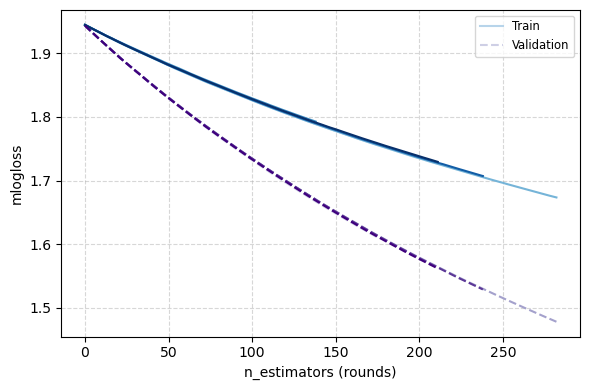

In [30]:
plt.figure(figsize=(6, 4))

# Colors for folds
colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Purples(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(1, n_folds + 1)):
    # Extract the data for this fold
    fold_data = metrics_df[metrics_df['fold_idx'] == fold_idx]

    # Extract mlogloss values
    mlogloss_train = fold_data['train_mlogloss']
    mlogloss_val = fold_data['val_mlogloss']
    n_estimators = fold_data['n_estimators']  # n_estimators column is same for each fold

    # Plot the mlogloss across n_estimators
    plt.plot(n_estimators, mlogloss_train, color=colors_train[idx], linestyle='-', label='Train' if idx == 0 else "")
    plt.plot(n_estimators, mlogloss_val, color=colors_val[idx], linestyle='--', label='Validation' if idx == 0 else "")

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('mlogloss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears only once
plt.legend(loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_mlogloss.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Multiclass error across folds

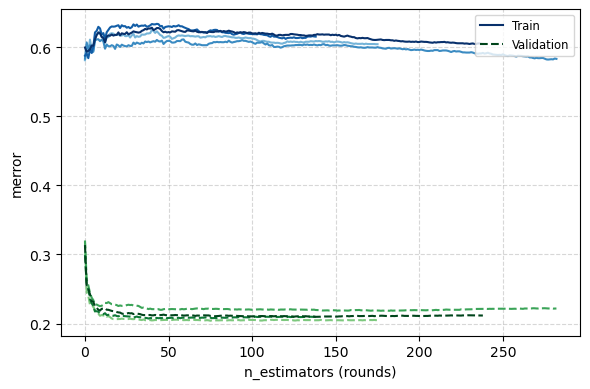

In [31]:
plt.figure(figsize=(6, 4))

colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Greens(np.linspace(0.3, 1, n_folds))
colors_test = plt.cm.Reds(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(0, n_folds)):
    # Extract the list of mlogloss values for this fold
    fold_data = metrics_df[metrics_df['fold_idx'] == fold_idx]
          
    merror_train = fold_data['train_merror'] 
    merror_val = fold_data['val_merror']      
    n_estimators = fold_data['n_estimators']
    
    # Plot the mlogloss across epochs
    plt.plot(n_estimators, merror_train, color=colors_train[idx], linestyle='-', label=f'Train')
    plt.plot(n_estimators, merror_val, color=colors_val[idx], linestyle='--', label=f'Validation')

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('merror')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears once
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_merror.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Model AUC across folds

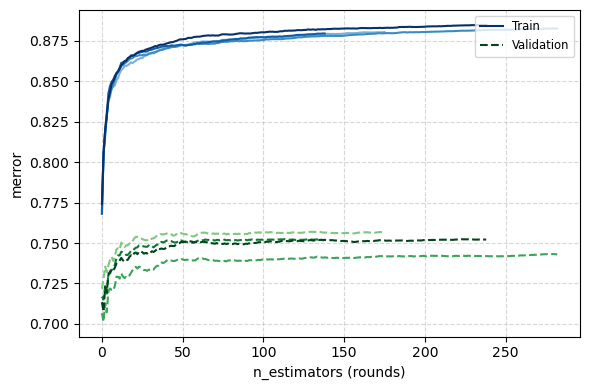

In [32]:
plt.figure(figsize=(6, 4))

colors_train = plt.cm.Blues(np.linspace(0.3, 1, n_folds))
colors_val = plt.cm.Greens(np.linspace(0.3, 1, n_folds))
colors_test = plt.cm.Reds(np.linspace(0.3, 1, n_folds))

# Loop through each fold to plot mlogloss across epochs
for idx, fold_idx in enumerate(range(0, n_folds)):
    # Extract the list of mlogloss values for this fold
    fold_data = metrics_df[metrics_df['fold_idx'] == fold_idx]
          
    auc_train = fold_data['train_auc']
    auc_val = fold_data['val_auc']     
    n_estimators = fold_data['n_estimators']

    # Plot the mlogloss across epochs
    plt.plot(n_estimators, auc_train, color=colors_train[idx], linestyle='-', label=f'Train')
    plt.plot(n_estimators, auc_val, color=colors_val[idx], linestyle='--', label=f'Validation')

# Add plot labels and legend
plt.xlabel('n_estimators (rounds)')
plt.ylabel('merror')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Create a custom legend that appears once
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper right', fontsize='small')

# Save the plot
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_auc.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Bar chart of correct against true

In [33]:
code_mapping = dict(zip(ref['code'], ref['class_code']))
print(code_mapping)

{0: 'TL', 1: 'WS', 2: 'CN', 3: 'AP', 4: 'SL', 5: 'TG', 6: 'CS'}


In [34]:
preds_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label,TL,WS,CN,AP,SL,TG,CS
0,1,0,0,TL,TL,0.156947,0.133550,0.139882,0.132393,0.136582,0.144263,0.156384
1,1,0,0,TL,TL,0.157247,0.135887,0.145709,0.131995,0.138697,0.133241,0.157225
2,1,0,6,TL,CS,0.135078,0.139017,0.133368,0.136928,0.132963,0.134384,0.188262
3,1,0,6,TL,CS,0.138697,0.154000,0.135562,0.137845,0.133445,0.132696,0.167755
4,1,0,6,TL,CS,0.153550,0.143387,0.137141,0.135677,0.137133,0.133175,0.159937


In [35]:
# Count the number of correct
preds_df['correct'] = preds_df['true_label'] == preds_df['pred_label']
correct_df = preds_df.groupby(['fold_idx', 'true_label']).agg(correct_count=('correct', 'sum')).reset_index()
correct_df = correct_df.groupby('true_label')['correct_count'].agg(['mean', 'std']).reset_index()
# Get total counts of true labels
total_counts = preds_df.groupby(['fold_idx', 'true_label']).size().reset_index(name='total_count')
total_counts_mn = total_counts.groupby('true_label')['total_count'].mean().reset_index()
# Merge back to data frame
correct_df = correct_df.merge(total_counts_mn, on='true_label', how='left')
correct_df.head()

,true_label,mean,std,total_count
0,AP,771.0,0.000000,1624.0
1,CN,60.6,26.053791,552.0
2,CS,16513.2,194.381583,17313.0
3,SL,0.0,0.000000,46.0
4,TG,17.2,1.303840,46.0


In [ ]:
# Generate the classification reports

In [36]:
all_reports = [] # to store the classification reports for each fold
class_codes = list(preds_df['true_label'].unique())
print(class_codes)

# Iterate over the folds
for fold_idx in results_df['fold_idx'].unique():
    print(f"Create CR for fold [{fold_idx}]")

    fold_preds_df = preds_df[preds_df['fold_idx'] == fold_idx]

    print(fold_preds_df.correct.value_counts())
    
    # Gather the true and predicted labels
    true_labs_fold = fold_preds_df['true_label']
    pred_labs_fold = fold_preds_df['pred_label']

    # Generate the classification report
    cr_fold = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
    cr_fold['fold_idx'] = fold_idx
    cr_fold = cr_fold.reset_index().rename(columns={'index': 'class_code'})
    cr_fold = cr_fold[cr_fold['class_code'].isin(class_codes)] # keep only the per class metrics (i.e., not the weighted average)
    all_reports.append(cr_fold)

# Combine the reports
cr_df = pd.concat(all_reports, axis=0)

# Save the report as a CSV
cr_df.to_csv(os.path.join(results_dir, 'denver-xgboost-cv_classification_reports.csv'))
print(cr_df)

['TL', 'WS', 'CN', 'AP', 'SL', 'TG', 'CS']
Create CR for fold [1]
correct
True     17720
False     4559
Name: count, dtype: int64
Create CR for fold [2]
correct
True     17394
False     4885
Name: count, dtype: int64
Create CR for fold [3]
correct
True     17643
False     4636
Name: count, dtype: int64
Create CR for fold [4]
correct
True     17597
False     4682
Name: count, dtype: int64
Create CR for fold [5]
correct
True     17728
False     4551
Name: count, dtype: int64
  class_code  precision    recall  f1-score  support  fold_idx
0         AP   0.798137  0.474754  0.595367   1624.0         1
1         CN   0.318408  0.115942  0.169987    552.0         1
2         CS   0.824500  0.958702  0.886551  17313.0         1
3         SL   0.000000  0.000000  0.000000     46.0         1
4         TG   0.044693  0.347826  0.079208     46.0         1
5         TL   0.391304  0.110721  0.172603    569.0         1
6         WS   0.451193  0.097698  0.160618   2129.0         1
0         AP   0.7

In [37]:
# Calculate the mean metrics across all folds
cr_summary = cr_df[['class_code', 'precision', 'recall', 'f1-score']].groupby('class_code').agg(['mean', 'std']).reset_index()
cr_summary.columns = ['class_code', 'precision', 'precision_sd', 
                      'recall', 'recall_sd', 
                      'f1-score', 'f1-score_sd']
cr_summary

,class_code,precision,precision_sd,recall,recall_sd,f1-score,f1-score_sd
0,AP,0.798137,0.000000,0.474754,0.000000,0.595367,0.000000
1,CN,0.303094,0.040946,0.109783,0.047199,0.156782,0.048778
2,CS,0.823666,0.003254,0.953804,0.011227,0.883932,0.003750
3,SL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TG,0.041513,0.004868,0.373913,0.028344,0.074541,0.007308
5,TL,0.373856,0.057023,0.111775,0.026380,0.169177,0.024502
6,WS,0.420918,0.030648,0.089620,0.044418,0.142251,0.064976


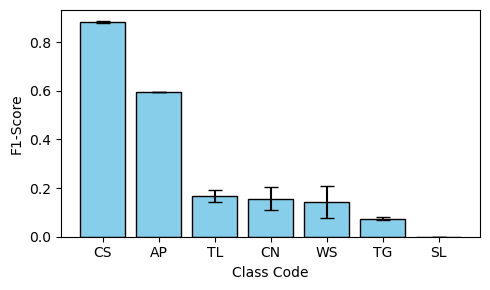

In [38]:
cr_summary = cr_summary.sort_values(by='f1-score', ascending=False)

plt.figure(figsize=(5, 3))
plt.bar(cr_summary['class_code'], cr_summary['f1-score'], 
        yerr=cr_summary['f1-score_sd'], capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Class Code')
plt.ylabel('F1-Score')
plt.tight_layout()

out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_mean_f1-score_bar.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Identify the best model from the folds

In [39]:
f1_scores_wt = [] # to store the weighted f1-scores
for fold_idx in cr_df['fold_idx'].unique():
    # Filter data for the current fold
    fold_data = cr_df[cr_df['fold_idx'] == fold_idx]
    
    # Calculate the weighted F1-score for this fold
    total_support = fold_data['support'].sum()
    weighted_f1 = (fold_data['f1-score'] * fold_data['support']).sum() / total_support
    
    # Append the results
    f1_scores_wt.append({'fold_idx': fold_idx, 'weighted_f1_score': weighted_f1})

# Convert to a DataFrame
f1_scores_wt_df = pd.DataFrame(f1_scores_wt)

# Identify the best-performing fold
best_fold = f1_scores_wt_df.loc[f1_scores_wt_df['weighted_f1_score'].idxmax()]
print(f"Best performing fold is Fold {int(best_fold['fold_idx'])} with a weighted F1-score of {best_fold['weighted_f1_score']:.4f}")

Best performing fold is Fold 1 with a weighted F1-score of 0.7565


In [40]:
best_fold_df = preds_df[preds_df['fold_idx'] == int(best_fold['fold_idx'])]
best_fold_df.head()

,fold_idx,true_code,pred_code,true_label,pred_label,TL,WS,CN,AP,SL,TG,CS,correct
0,1,0,0,TL,TL,0.156947,0.133550,0.139882,0.132393,0.136582,0.144263,0.156384,True
1,1,0,0,TL,TL,0.157247,0.135887,0.145709,0.131995,0.138697,0.133241,0.157225,True
2,1,0,6,TL,CS,0.135078,0.139017,0.133368,0.136928,0.132963,0.134384,0.188262,False
3,1,0,6,TL,CS,0.138697,0.154000,0.135562,0.137845,0.133445,0.132696,0.167755,False
4,1,0,6,TL,CS,0.153550,0.143387,0.137141,0.135677,0.137133,0.133175,0.159937,False


In [41]:
# Gather the report for the best model

# Gather the true and predicted labels
true_labs_fold = best_fold_df['true_code']
pred_labs_fold = best_fold_df['pred_code']

# Generate the classification report
cr_best = pd.DataFrame(classification_report(true_labs_fold, pred_labs_fold, output_dict=True)).transpose()
print(cr_best)

              precision    recall  f1-score       support
0              0.391304  0.110721  0.172603    569.000000
1              0.451193  0.097698  0.160618   2129.000000
2              0.318408  0.115942  0.169987    552.000000
3              0.798137  0.474754  0.595367   1624.000000
4              0.000000  0.000000  0.000000     46.000000
5              0.044693  0.347826  0.079208     46.000000
6              0.824500  0.958702  0.886551  17313.000000
accuracy       0.795368  0.795368  0.795368      0.795368
macro avg      0.404033  0.300806  0.294905  22279.000000
weighted avg   0.759989  0.795368  0.756469  22279.000000


In [ ]:
# Generate confusion matrices

In [42]:
class_names = list(code_mapping.values())
print(class_names)

['TL', 'WS', 'CN', 'AP', 'SL', 'TG', 'CS']


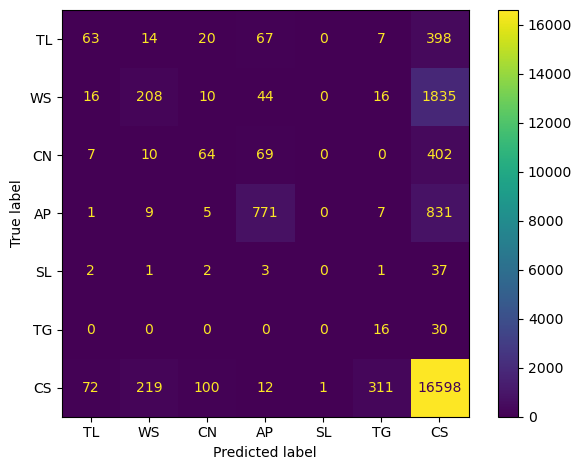

In [43]:
# For the best performing model (Fold 2)
cm_best = confusion_matrix(
    best_fold_df['true_label'], 
    best_fold_df['pred_label'], 
    labels=class_names)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=class_names)
disp.plot(cmap='viridis')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_confusion_matrix_bestFold.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()

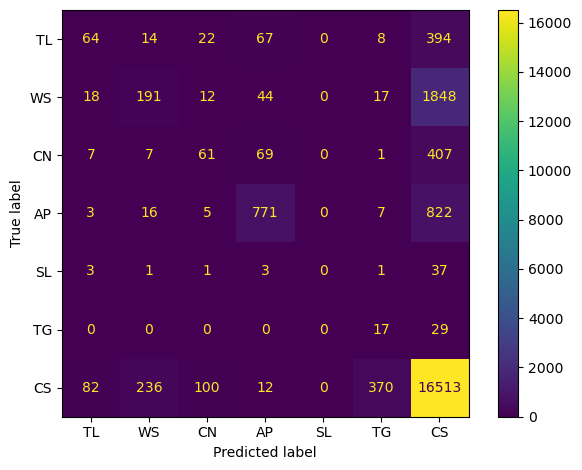

In [44]:
average_cm = np.zeros((len(class_names), len(class_names)))

# Iterate through each fold and accumulate the confusion matrix
for fold_idx in preds_df['fold_idx'].unique():
    fold_preds = preds_df[preds_df['fold_idx'] == fold_idx]
    cm_fold = confusion_matrix(
        fold_preds['true_label'], 
        fold_preds['pred_label'], 
        labels=class_names
    )
    average_cm += cm_fold

# Divide by the number of folds to get the average
average_cm /= len(preds_df['fold_idx'].unique())
average_cm = np.rint(average_cm).astype(int)

# Plot the confusion matrix
disp_avg = ConfusionMatrixDisplay(confusion_matrix=average_cm, display_labels=class_names)
disp_avg.plot(cmap='viridis', values_format='d')
plt.tight_layout()

# Save it
out_png = os.path.join(results_dir, 'figures/denver-xgboost-cv_confusion_matrix_average.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')  

plt.show()

In [45]:
gc.collect()

3651